<a href="https://colab.research.google.com/github/SAMAWELJABALLI/TweetsSentimentAnalysis/blob/main/SentimentAnalysis_Sequential_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


**Data importing**

In [2]:
train = pd.read_csv('/content/train.csv')

**Data exploration**

In [3]:
train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [4]:
#Let's get the dataset lenght
len(train)

27481

In [5]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [6]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537



**Data cleaning**

In [7]:
#Let's keep only the columns that we're going to use
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [8]:
#Is there any null value?
train["selected_text"].isnull().sum()

1

In [9]:
#Let's fill the only null value.
train["selected_text"].fillna("No content", inplace = True)

**The next steps about data cleaning will be:**
* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* aboutConvert list of texts to Numpy array




In [10]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [11]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [14]:
len(data_words)

27481

In [15]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [17]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [19]:
data = np.array(data)
data

array(['have responded if were going', 'sooo sad', 'bullying me', ...,
       'yay good for both of you', 'but it was worth it',
       'all this flirting going on the atg smiles yay hugs'],
      dtype='<U135')


**Label encoding**

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [20]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [23]:
len(labels)

27481

**Data sequencing and splitting**

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [25]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [41]:
tweets

array([[   0,    0,    0, ...,   68,  146,   41],
       [   0,    0,    0, ...,    0,  397,   65],
       [   0,    0,    0, ...,    0,    0,   11],
       ...,
       [   0,    0,    0, ...,  372,   10,    3],
       [   0,    0,    0, ...,   24,  542,    4],
       [   0,    0,    0, ..., 2424,  199,  657]], dtype=int32)

In [30]:
print (labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


**Splitting the data**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [32]:
20610/6871


2.999563382331538

**Model building**

Alright, in the next cells I'll guide you through the process of building 3 Recurrent Neural Networks. I'll implement sequential models from the Keras API to achieve this task. Essentially, I'll start with a single layer LSTM network which is known by achieving good results in NLP tasks when the dataset is relatively small (I could have started with a SimpleRNN which is even simpler, but to be honest it's actually not deployed in production environments because it is too simple - however I'll leave it commented in case you want to know it's built). The next one will be a Bidirectional LSTM model, a more complex one and this particular one is known to achieve great metrics when talking about text classification. To go beyond the classic NLP approach, finally we'll implement a very unusual model: a Convolutional 1D network, known as well by delivering good metrics when talking about NLP. If everything goes ok, we should get the best results with the BidRNN, let's see what happens.

Let's get hands on:

**SimpleRNN model (Bonus)**

In [42]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='softmax'))


model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

Epoch 1/5
645/645 [==============================] - 25s 36ms/step - loss: 0.9074 - accuracy: 0.5652 - val_loss: 0.6032 - val_accuracy: 0.7677

Epoch 00001: val_accuracy improved from -inf to 0.76772, saving model to best_model0.hdf5
Epoch 2/5
645/645 [==============================] - 22s 35ms/step - loss: 0.5427 - accuracy: 0.7910 - val_loss: 0.5491 - val_accuracy: 0.7703

Epoch 00002: val_accuracy improved from 0.76772 to 0.77034, saving model to best_model0.hdf5
Epoch 3/5
645/645 [==============================] - 22s 35ms/step - loss: 0.4623 - accuracy: 0.8250 - val_loss: 0.5174 - val_accuracy: 0.7938

Epoch 00003: val_accuracy improved from 0.77034 to 0.79377, saving model to best_model0.hdf5
Epoch 4/5
645/645 [==============================] - 23s 35ms/step - loss: 0.4433 - accuracy: 0.8315 - val_loss: 0.5041 - val_accuracy: 0.7976

Epoch 00004: val_accuracy improved from 0.79377 to 0.79755, saving model to best_model0.hdf5
Epoch 5/5
645/645 [==============================] - 23

**Single LSTM layer model**

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

**Bidirectional LTSM model**

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])


**Best model validation**

(Before final commit, the best model obtained was the BidRNN)

In [45]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model1.hdf5")

In [46]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 3s - loss: 0.4332 - accuracy: 0.8428
Model accuracy:  0.8428176641464233


In [47]:
predictions = best_model.predict(X_test)


**Confusion matrix**

Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [48]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

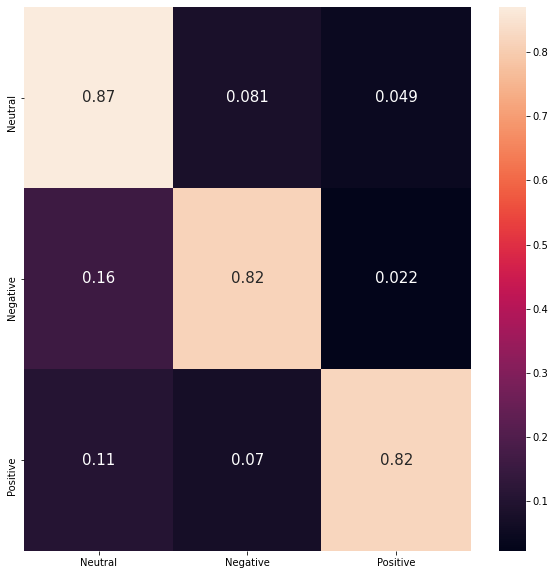

In [51]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it performs on some test text.

In [52]:
sentiment = ['Neutral','Negative','Positive']

In [59]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

**Preparing model for AWS SageMaker**

In [54]:
#Saving weights and tokenizer so we can reduce training time on SageMaker

# serialize model to JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_model.save_weights("model-weights.h5")
print("Model saved")

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Tokenizer saved')

Model saved
Tokenizer saved
